<a href="https://colab.research.google.com/github/Sarjunt04/BTC-Risk/blob/main/Risk_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from google.colab import files

# for rolling means
pd.options.mode.chained_assignment = None  # to silence SettingWithCopyWarning


In [3]:
# data from Yahoo Finance
btc = yf.download("BTC-USD", start = '2014-09-17', progress=False)

# remove column names 'BTC-USD'
btc.columns = [col[0] if isinstance(col, tuple) else col for col in btc.columns]

# drop missing values and reset index
btc = btc.dropna().reset_index()

# rename columns
btc = btc.rename(columns={
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume',
    'Date': 'date'
})

btc = btc[['date', 'high', 'low', 'close', 'volume']]
btc.head()


/tmp/ipython-input-1752433015.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start = '2014-09-17', progress=False)


,date,high,low,close,volume
0,2014-09-17,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,413.104004,424.440002,34483200
2,2014-09-19,427.834991,384.532013,394.795990,37919700
3,2014-09-20,423.295990,389.882996,408.903992,36863600
4,2014-09-21,412.425995,393.181000,398.821014,26580100


In [4]:
uploaded = files.upload()

# load older data
btc_old = pd.read_csv("Bitcoin_2010-2014.csv", sep=";")
btc_old = btc_old[::-1].copy()

# convert date column
btc_old['date'] = pd.to_datetime(btc_old['timeOpen'].str.split('T').str[0])
btc_old = btc_old[['date', 'high', 'low', 'close', 'volume']]

# combine with YF data
btc_all = pd.concat([btc_old, btc], ignore_index=True)
btc_all = btc_all.sort_values("date").reset_index(drop=True)


Saving Bitcoin_2010-2014.csv to Bitcoin_2010-2014.csv


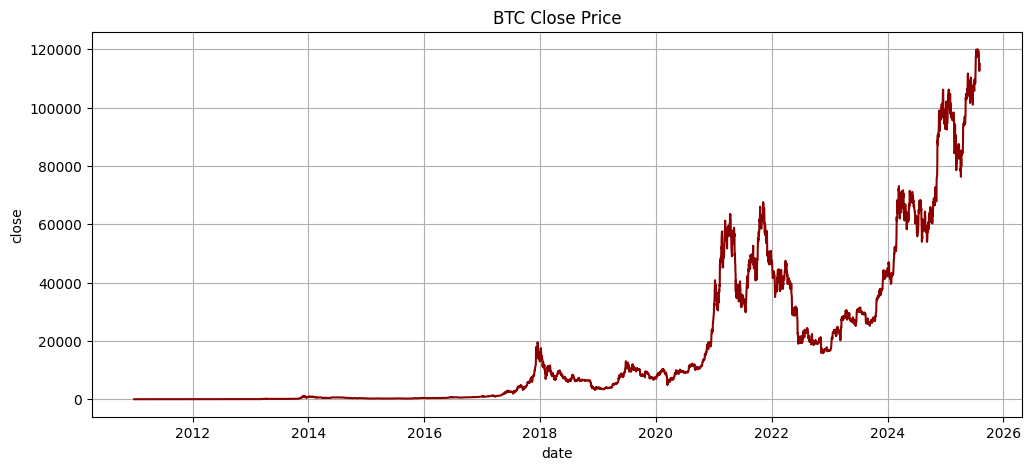

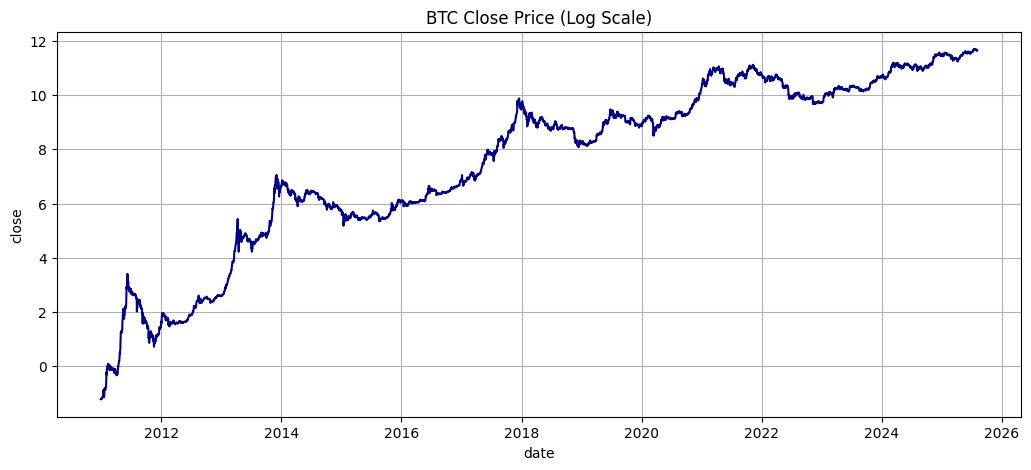

In [5]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=btc_all, x='date', y='close', color='darkred')
plt.title("BTC Close Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(12.44, 5))
sns.lineplot(data=btc_all, x='date', y=np.log(btc_all['close']), color='darkblue')
plt.title("BTC Close Price (Log Scale)")
plt.grid(True)
plt.show()


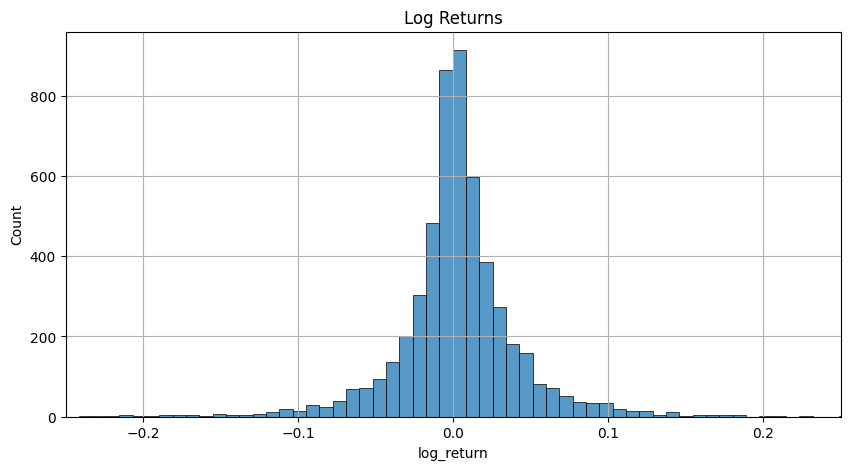

In [6]:
btc_all['log_price'] = np.log(btc_all['close'])
btc_all['log_return'] = btc_all['log_price'].diff()

# histogram of log returns
plt.figure(figsize=(10, 5))
sns.histplot(btc_all['log_return'].dropna(), bins=100, kde=False)
plt.xlim(-0.25, 0.25)
plt.title("Log Returns")
plt.grid(True)
plt.show()


In [7]:
from pandas.api.types import is_numeric_dtype

# upper and lower tail
btc_all['upper_tail'] = btc_all['high'] - btc_all['close']
btc_all['lower_tail'] = btc_all['close'] - btc_all['low']

# rolling averages (weekly = 7 days, so 8w = 56d, 50w = 350d)
btc_all['sma8'] = btc_all['close'].rolling(window=56, min_periods=1).mean()
btc_all['sma50'] = btc_all['close'].rolling(window=350, min_periods=1).mean()

# fill early NA with cumulative mean for consistency
btc_all['sma8'] = btc_all['sma8'].fillna(btc_all['close'].expanding().mean())
btc_all['sma50'] = btc_all['sma50'].fillna(btc_all['close'].expanding().mean())


In [70]:
# diminishing return time factor
btc_all['time_factor'] = 1 + np.exp(np.arange(len(btc_all)) / 5000)

# Raw risk
btc_all['sma_risk_raw'] = (btc_all['sma8'] * btc_all['time_factor']) / btc_all['sma50']

# normalize to [0,1]
min_risk = btc_all['sma_risk_raw'].min()
max_risk = btc_all['sma_risk_raw'].max()

# at time of fit, min = 1.00789, max = 8.20091
btc_all['sma_risk'] = (btc_all['sma_risk_raw'] - min_risk) / (max_risk - min_risk)

Risk Today: 0.5315495646417117


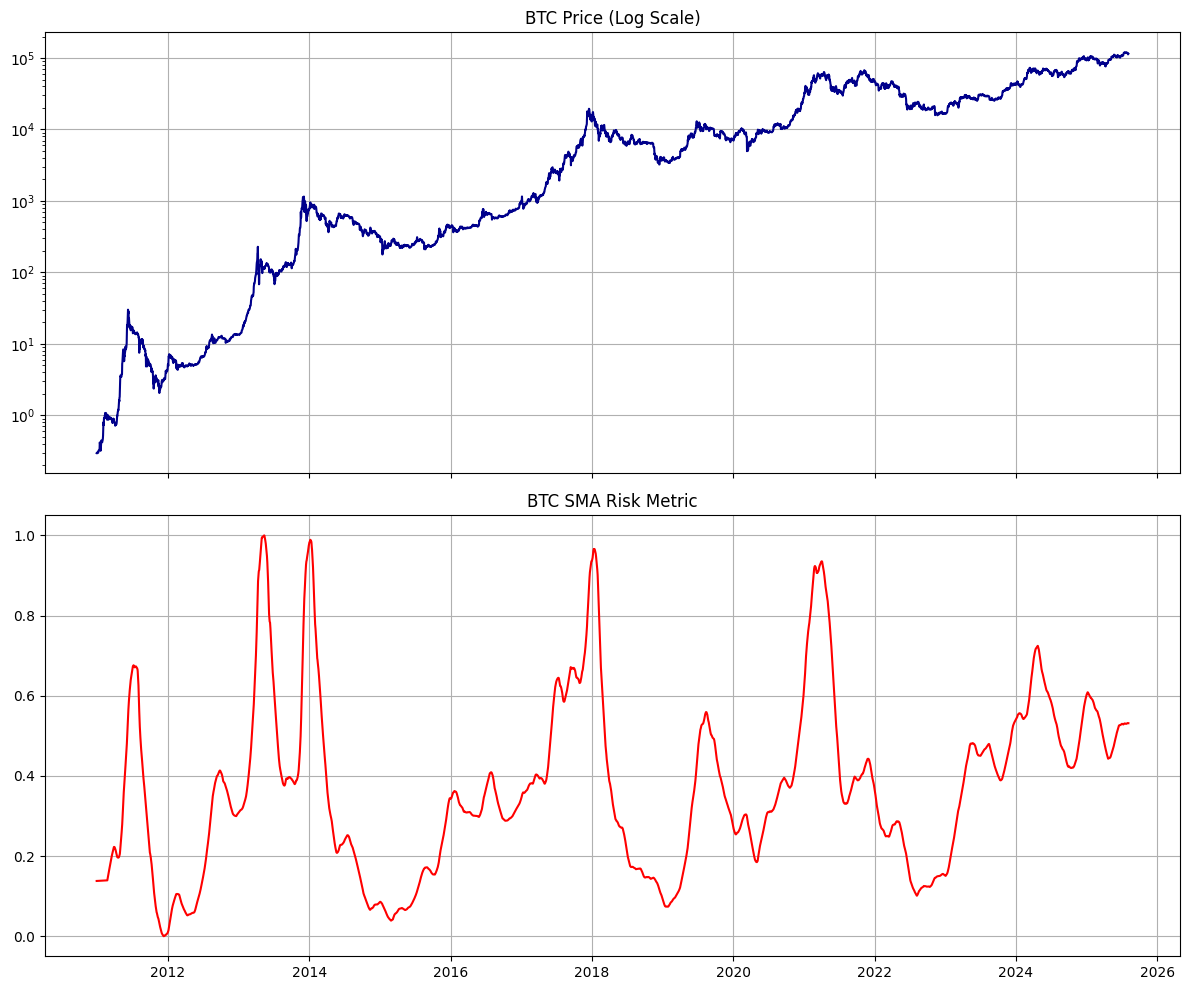

In [71]:
# most recent entry
print('Risk Today: ' + str(btc_all['sma_risk'].iloc[-1]))

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# log Price
axs[0].plot(btc_all['date'], btc_all['close'], color='darkblue')
axs[0].set_yscale("log")
axs[0].set_title("BTC Price (Log Scale)")
axs[0].grid(True)

# sma risk netric
axs[1].plot(btc_all['date'], btc_all['sma_risk'], color='red')
axs[1].set_title("BTC SMA Risk Metric")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# we see that risk has less extreme peaks and troughs as time goes on, last cycle peaking at 0.93 and bottoming at 0.12

In [72]:
# Backtest: start with 1000 weekly buy/sale of BTC based on risk:
#                            invest 4% .3, 8% .2, 25% .1
#                            sell 4% at .7, 10% .8, 40% .9
#           reset total amount of cash (BTC) after final BTC sell (buy). e.g. if we sell all remaining BTC in 2014, ending up with, 2000, our weekly buy would be worth 0.04 * 2000 = 80 for .3-.4 risk

btc_weekly = btc_all.set_index('date').resample('W-FRI').last().dropna().reset_index()
btc_weekly = btc_weekly[btc_weekly['date'] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)

# initialize backtest variables
initial_value = 1000
btc_holdings = 0
cash = initial_value
total_value = initial_value

btc_history = []

for i, row in btc_weekly.iterrows():
    price = row['close']
    risk = row['sma_risk']

    # decide buy/sell percent
    buy_pct = 0
    sell_pct = 0

    if 0.1 <= risk < 0.2:
        buy_pct = 0.05
    elif risk < 0.1:
        buy_pct = 0.25
    elif 0.7 <= risk < 0.8:
        sell_pct = 0.05
    elif 0.8 <= risk < 0.9:
        sell_pct = 0.10
    elif risk >= 0.9:
        sell_pct = 0.40

    # buy BTC
    if buy_pct > 0:
        buy_amount = buy_pct * total_value
        if buy_amount > cash:
            buy_amount = cash  # can't spend more than cash
        btc_holdings += buy_amount / price
        cash -= buy_amount

    # sell BTC
    elif sell_pct > 0:
        sell_btc = sell_pct * btc_holdings
        btc_holdings -= sell_btc
        cash += sell_btc * price

    # calculate portfolio value
    total_value = cash + btc_holdings * price

    # save history
    btc_history.append({
        'date': row['date'],
        'price': price,
        'risk': risk,
        'btc': btc_holdings,
        'cash': cash,
        'total_value': total_value
    })

# convert to DataFrame for analysis
backtest_df = pd.DataFrame(btc_history)

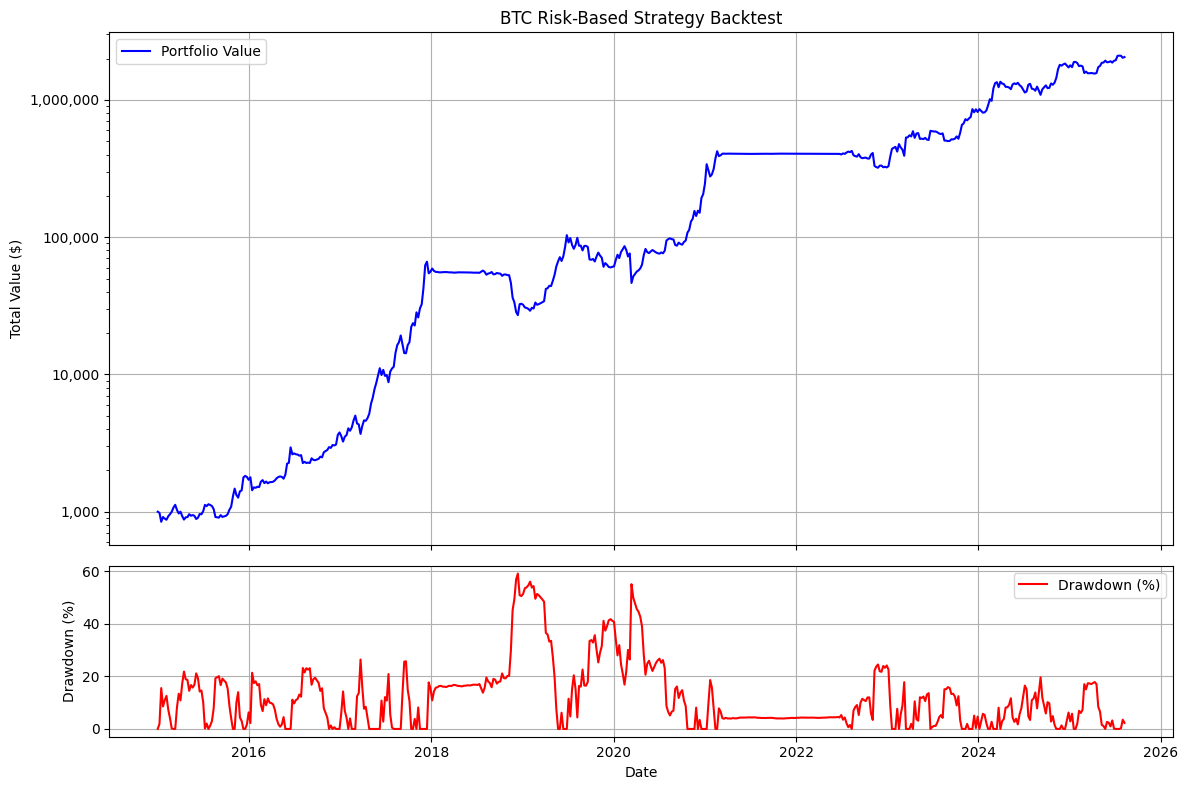

In [73]:
# drawdowns
backtest_df['peak'] = backtest_df['total_value'].cummax()
backtest_df['drawdown'] = backtest_df['peak'] - backtest_df['total_value']
backtest_df['drawdown_pct'] = backtest_df['drawdown'] / backtest_df['peak']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Portfolio Value Plot (top) ---
ax1.plot(backtest_df['date'], backtest_df['total_value'], label='Portfolio Value', color='blue')
ax1.set_title('BTC Risk-Based Strategy Backtest')
ax1.set_ylabel('Total Value ($)')
ax1.grid(True)
ax1.set_yscale('log')  # Optional: remove this line for linear
ax1.legend()
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))  # Force plain formatting

# --- Drawdown Plot (bottom) ---
ax2.plot(backtest_df['date'], backtest_df['drawdown_pct'] * 100, color='red', label='Drawdown (%)')
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
